In [57]:
# author: Tom Stone <tomstone@stanford.edu>
# license: BSD 3-clause

import somata
from somata.basic_models import StateSpaceModel as Ssm
from somata.basic_models import OscillatorModel as Osc
from somata.basic_models import AutoRegModel as Arn
from somata.switching.vb import VBSwitchModel
from somata.switching.traditional import switching as traditional_switching

import matplotlib.pyplot as plt

from copy import deepcopy

import numpy as np
import pickle as pkl

Lets load in some data. These five objects are all lists of `np.array` objects, the sampling frequency is 100 Hz

In [53]:
with open('clean_30s_segments.pkl', 'rb') as f:
    clean_30s_segments = pkl.load(f)

with open('inhom_artifacts.pkl', 'rb') as g:
    inhom_artifacts = pkl.load(g)

with open('segments.pkl', 'rb') as h:
    data_dict = pkl.load(h)
    cleans = data_dict['cleans']
    noises = data_dict['noises']
    tests  = data_dict['tests']

Lets take a look at one of these artifacts

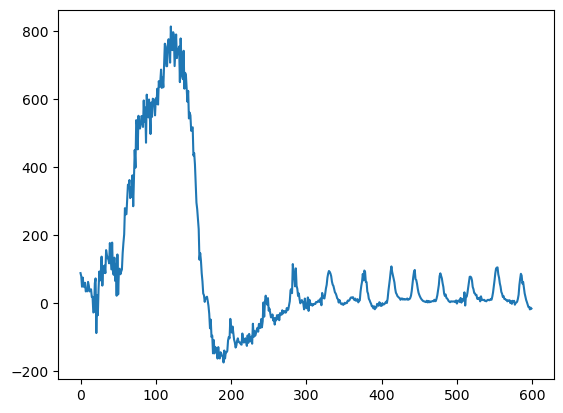

In [291]:
plt.plot(inhom_artifacts[1].T)

First, we set up a model of the data and a model of the artifact. These parameters were learned on another dataset

In [300]:
data_model = Osc(a = [0.969, 0.946], freq = [1.15, 10.29], sigma2=[1.646, 2.633], R=np.array([[0.301]]), Fs = 100)

artifact_model = Arn(coeff=[1.271, -0.301], sigma2=370.388, Fs = 100)

Now we create an array of `Ssm` objects to switch between, and write down the observation matrices that leave out the artifacts

In [301]:
models_to_switch = [data_model.copy().ssm(), data_model.copy().concat_(artifact_model.copy())]
Gs = [np.array([[1,0,1,0]]), np.array([[1,0,1,0,0,0]])]

## Synthetic data (real data + real artifact)

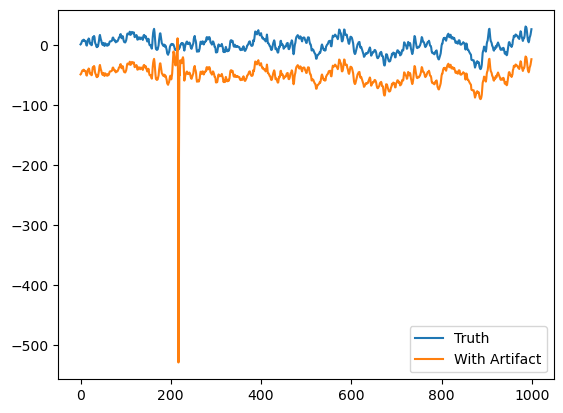

In [302]:
y = cleans[0]
y_test = deepcopy(y)

index = 5 # this might be the best example, try with other artifacts to see the successes and failures

y_test[[0],200:200+inhom_artifacts[index].shape[1]] += inhom_artifacts[index] # this particular artifact was just too large
plt.plot(y.T)
plt.plot(y_test.T-50)
plt.legend(['Truth', 'With Artifact'])

In [303]:
Mprob, _ = traditional_switching(models_to_switch, y=y_test, method='ab pari') # interpolated density

x_t = Ssm.par_kalman(models_to_switch, return_dict=True, method='dejong', skip_interp=False)['x_t_n_all']

In [304]:
y_cleaned = sum([(Gs[i] @ x_t[i][:,1:]) * Mprob[i,:] for i in range(len(models_to_switch))])

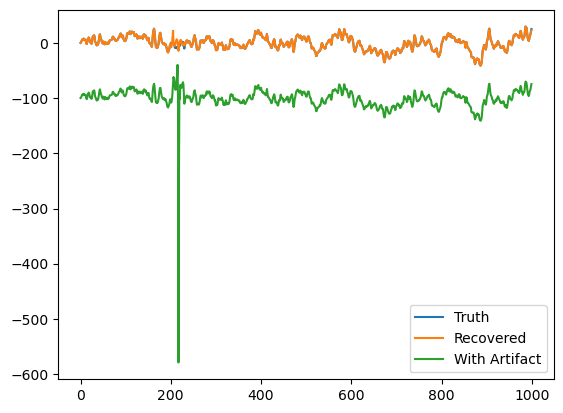

In [305]:
plt.plot(y.T)
plt.plot(y_cleaned.T)
plt.plot(y_test.T - 100)
plt.legend(['Truth', 'Recovered', 'With Artifact'])
plt.show()

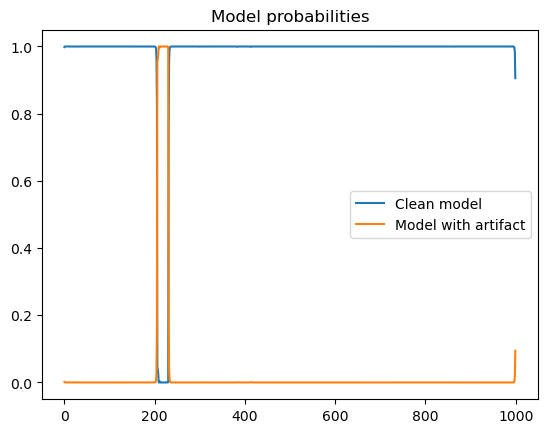

In [307]:
plt.plot(Mprob.T)
plt.legend(['Clean model', 'Model with artifact'])
plt.title('Model probabilities')
plt.show()

## Real data that contain artifacts
Play around with different `sigma2` in the `artifact_model` object.

The artifact shown is a 'Train of Four' artifact, which comes from a device that measures response to electrical stimuli to gauge depth of anesthesia, and is a pain for our research.

This time, we will have two artifact models with different state noise covariances (hence different scales of artifact)

In [334]:
data_model = Osc(a = [0.969, 0.946], freq = [1.15, 10.29], sigma2=[1.646, 2.633], R=np.array([[0.301]]), Fs = 100)

artifact_model  = Arn(coeff=[1.271, -0.301], sigma2=37.388, Fs = 100)
artifact_model2 = Arn(coeff=[1.271, -0.301], sigma2=37.388 * 5, Fs = 100)

models_to_switch = [
    data_model.ssm()
    , data_model.ssm().concat_(artifact_model)
    , data_model.ssm().concat_(artifact_model2)
]
Gs = [
    np.array([[1,0,1,0]])
    , np.array([[1,0,1,0,0,0]])
    , np.array([[1,0,1,0,0,0]])
] 

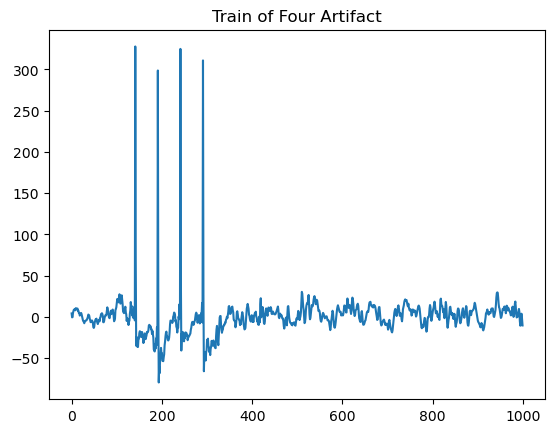

In [335]:
y_test = tests[18]
plt.plot(y_test.T)
plt.title('Train of Four Artifact')
plt.show()

In [336]:
Mprob, _ = traditional_switching(models_to_switch, y=y_test, method='ab pari') # interpolated density

x_t = Ssm.par_kalman(models_to_switch, return_dict=True, method='dejong', skip_interp=False)['x_t_n_all']

y_cleaned = sum([(Gs[i] @ x_t[i][:,1:]) * Mprob[i,:] for i in range(len(models_to_switch))])

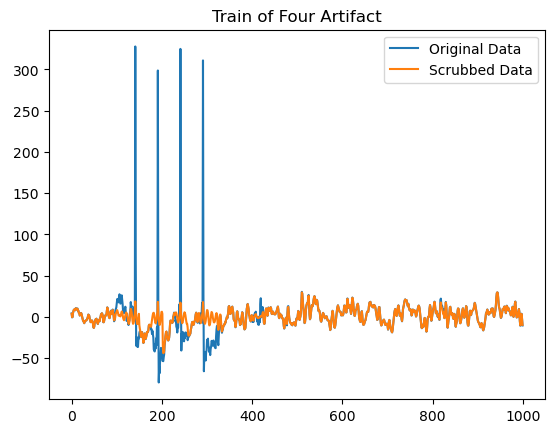

In [337]:
plt.plot(y_test.T)
plt.plot(y_cleaned.T)
plt.legend(['Original Data', 'Scrubbed Data'])
plt.title('Train of Four Artifact')
plt.show()

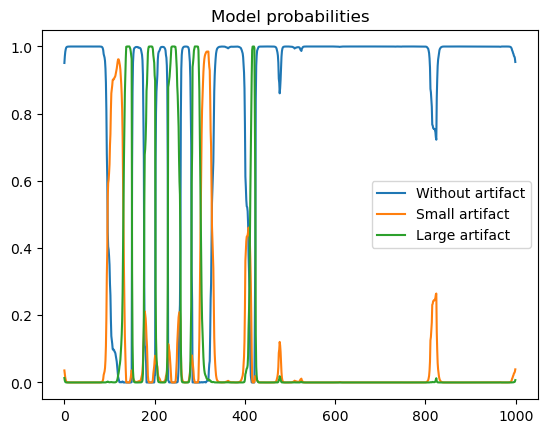

In [338]:
plt.plot(Mprob.T)
plt.legend(['Without artifact', 'Small artifact', 'Large artifact'])
plt.title('Model probabilities')
plt.show()

## Another real data example

In [329]:
data_model = Osc(a = [0.969, 0.946], freq = [1.15, 10.29], sigma2=[1.646, 2.633], R=np.array([[0.301]]), Fs = 100)

artifact_model  = Arn(coeff=[1.271, -0.301], sigma2=37.388 / 5, Fs = 100)
artifact_model2 = Arn(coeff=[1.271, -0.301], sigma2=37.388    , Fs = 100)
artifact_model3 = Arn(coeff=[1.271, -0.301], sigma2=37.388 * 5, Fs = 100)

models_to_switch = [
    data_model.ssm()
    , data_model.ssm().concat_(artifact_model)
    , data_model.ssm().concat_(artifact_model2)
    , data_model.ssm().concat_(artifact_model3)
]
Gs = [
    np.array([[1,0,1,0]])
    , np.array([[1,0,1,0,0,0]])
    , np.array([[1,0,1,0,0,0]])
    , np.array([[1,0,1,0,0,0]])
] 

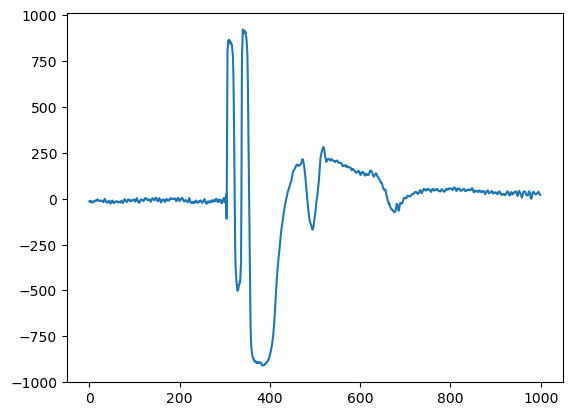

In [330]:
y_test = tests[25]
plt.plot(y_test.T)
plt.show()

In [331]:
Mprob, _ = traditional_switching(models_to_switch, y=y_test, method='ab pari') # interpolated density

x_t = Ssm.par_kalman(models_to_switch, return_dict=True, method='dejong', skip_interp=False)['x_t_n_all']

y_cleaned = sum([(Gs[i] @ x_t[i][:,1:]) * Mprob[i,:] for i in range(len(models_to_switch))])

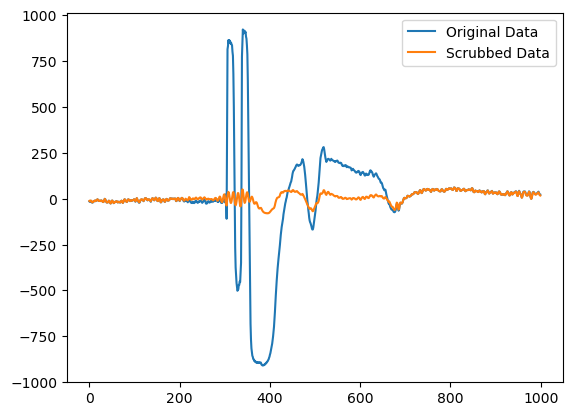

In [332]:
plt.plot(y_test.T)
plt.plot(y_cleaned.T)
plt.legend(['Original Data', 'Scrubbed Data'])
plt.show()

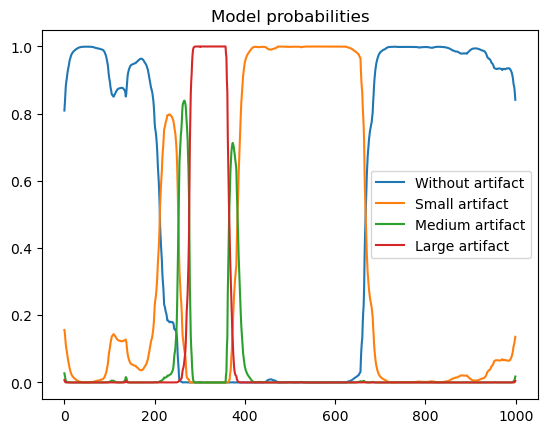

In [333]:
plt.plot(Mprob.T)
plt.legend(['Without artifact', 'Small artifact', 'Medium artifact', 'Large artifact'])
plt.title('Model probabilities')
plt.show()